In [1]:
import torch
import torch.distributions as D
import numpy as np
import random

/private/home/arjunsub/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed = 42):
    # Torch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Python RNG
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed()
seed_list=[]
n_runs=10
for i in range(n_runs):
    seed_list.append(random.randint(1,100))
print(seed_list)

[82, 15, 4, 95, 36, 32, 29, 18, 95, 14]


In [4]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(k, 1, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
results_dict = {}
alpha = 3
N_test = 100000
k = 2000

for covars_0_idx, covars_0 in enumerate([1 / (torch.arange(2, k + 2) * (torch.log(torch.arange(2, k + 2)) ** 2)), 1 / torch.pow(torch.arange(1, k + 1), 2)]):
    results_dict[covars_0_idx] = {}
    
    for beta_1 in [1, 0.5]:
        results_dict[covars_0_idx][beta_1] = {}
        
        for beta_2 in [1, 0.5]:
            results_dict[covars_0_idx][beta_1][beta_2] = {}
            
            N_train = int(beta_2 * 300)
            w_star_0 = 1 / torch.arange(1, k + 1).reshape(-1, 1)
            w_star_1 = 2 / torch.arange(1, k + 1).reshape(-1, 1)

            noise_sigma = 1
            noise = D.Normal(0, noise_sigma)

            p_list = torch.arange(0.0, 1.1, 0.1)

            excess_risk_list = torch.zeros((p_list.size(0), n_runs))
            k_star_list = torch.zeros((p_list.size(0), n_runs))
            bias_list = torch.zeros((p_list.size(0), n_runs))
            var_list = torch.zeros((p_list.size(0), n_runs))
            bound_list = torch.zeros((p_list.size(0), n_runs))

            for p_i, p in enumerate(p_list):
                print('p {}'.format(p))
                mix = D.Categorical(torch.tensor([p, 1 - p]))

                means_0 = torch.zeros(k)
                means_1 = torch.zeros(k)
                covars_1 = beta_1 * covars_0


                comp = D.Independent(D.Normal(torch.cat([means_0.reshape(1, -1), \
                                                         means_1.reshape(1, -1)]), \
                                              torch.cat([covars_0.reshape(1, -1) ** 0.5, \
                                                         covars_1.reshape(1, -1) ** 0.5])), 1)
                eigs_0 = covars_0
                eigs_1 = covars_1

                # gmm = D.MixtureSameFamily(mix, comp)
                all_eigs = p * eigs_0 + (1 - p) * eigs_1

                gamma = 0.99 / (alpha * all_eigs.sum())
                assert gamma < 1 / (alpha * all_eigs.sum())
                print('gamma: {}'.format(gamma))

                all_eigs_sorted_idx = torch.sort((1 - (1 - gamma * all_eigs) ** N_train) ** 2 / all_eigs, descending=True)[1]
                all_eigs_sorted_parens = all_eigs[all_eigs_sorted_idx]


                all_eigs_sorted_idx = torch.sort((1 - (1 - gamma * all_eigs) ** N_train) ** 2 / all_eigs ** 2, descending=True)[1]
                all_eigs_sorted_brackets = all_eigs[all_eigs_sorted_idx]

                for seed_i, seed in enumerate(seed_list):
                    # Generate training data
                    set_seed(seed)
                    x_train = []
                    y_train = []
                    for _ in range(N_train):
                        idx = mix.sample()
                        x_train.append(comp.sample()[idx].reshape(1, -1))
                        if idx.item() == 0:
                            y_train.append(torch.mm(x_train[-1], w_star_0) + noise.sample())
                        else:
                            y_train.append(torch.mm(x_train[-1], w_star_1))
                    x_train = torch.cat(x_train)
                    y_train = torch.cat(y_train)

                    # Generate test data
                    set_seed(seed)
                    x_test = comp.sample((N_test,))[:, 0, :]
                    y_test = torch.mm(x_test, w_star_0) + noise.sample((N_test, 1))

                    set_seed(seed)
                    model = LR()
                    criterion = torch.nn.MSELoss() 
                    optimizer = torch.optim.SGD(model.parameters(), lr=gamma)

                    # Train model
                    model.train()
                    w_list = []
                    for epoch in range(N_train):
                        w_list.append(model.linear.weight.detach())

                        set_seed(seed)
                        optimizer.zero_grad()
                        outputs = model(x_train[epoch].reshape(1, -1))

                        loss = criterion(outputs, y_train[epoch].reshape(1, -1)) / 2
                        loss.backward()
                        optimizer.step()

                    model.eval()
                    w_bar = torch.cat(w_list).mean(dim=0, keepdim=True)
                    with torch.no_grad():
                        model.linear.weight = torch.nn.Parameter(w_bar)
                    outputs = model(x_test)
                    loss = criterion(outputs, y_test)

                    model.eval()
                    with torch.no_grad():
                        model.linear.weight = torch.nn.Parameter(w_star_0.reshape(1, -1))
                    outputs = model(x_test)
                    best_loss = criterion(outputs, y_test)

                    excess_risk_list[p_i, seed_i] = loss.detach() - best_loss.detach()

                    # Compute bias bound
                    w_dist = ((w_list[0][0] - w_star_0[:, 0]) * (w_list[0][0] - w_star_0[:, 0])).sum()
                    if all_eigs_sorted_brackets[0] >= 1 / (gamma * N_train):
                        bias = eigs_0[0] * w_dist / ((gamma ** 2) * (N_train ** 2) * (all_eigs_sorted_brackets[0] ** 2))
                    else:
                        bias = eigs_0[0] * w_dist
                    bias_list[p_i, seed_i] = bias

                    # Compute k*
                    delta = all_eigs >= 1 / (gamma * N_train)
                    k_star = delta.sum()
                    k_star_list[p_i, seed_i] = k_star
                    delta_sorted_parens = all_eigs_sorted_parens >= 1 / (gamma * N_train)

                    # Compute variance bound
                    sigma_squared = torch.max(all_eigs ** -0.5 * \
                                    (p * eigs_0 + (1 - p) * alpha * torch.sum(w_star_0 * eigs_1 * w_star_0) * eigs_1) * \
                                     all_eigs ** -0.5)
                    var = 2 * alpha / (gamma * N_train)
                    w_dist = ((w_list[0][0] - w_star_0[:, 0])[delta] * (w_list[0][0] - w_star_0[:, 0])[delta]).sum() \
                                    + N_train * gamma * ((w_list[0][0] - w_star_0[:, 0])[~delta] * all_eigs[~delta] * (w_list[0][0] - w_star_0[:, 0])[~delta]).sum()
                    var = (var * w_dist + sigma_squared) / (1 - gamma * alpha * all_eigs.sum())
                    head = 1 / N_train * (eigs_0[:k_star] / all_eigs[delta_sorted_parens]).sum()
                    tail = N_train * (gamma ** 2) * (eigs_0[k_star:] * all_eigs[~delta_sorted_parens]).sum()
                    var = var * (head + tail)
                    var_list[p_i, seed_i] = var

                    bound_list[p_i, seed_i] = 2 * bias + 2 * var

                print('excess risk {}'.format(excess_risk_list[p_i].mean().item()))
                print('bias {}'.format(bias_list[p_i].mean().item()))
                print('k* {}'.format(k_star_list[p_i].mean().item()))
                print('var {}'.format(var_list[p_i].mean().item()))
                print('excess risk bound {}'.format(bound_list[p_i].mean().item()))
                print('ratio {}'.format((bound_list[p_i] / excess_risk_list[p_i]).mean()))
                print()
    
            results_dict[covars_0_idx][beta_1][beta_2] = [excess_risk_list, bound_list]
    

p 0.0
gamma: 0.16681896150112152
excess risk 1.1339613199234009
bias 2.0473601818084717
k* 8.0
var 361.59576416015625
excess risk bound 727.2862548828125
ratio 642.4954833984375

p 0.10000000149011612
gamma: 0.16681896150112152
excess risk 0.8871954083442688
bias 2.3064677715301514
k* 8.0
var 329.0806579589844
excess risk bound 662.7742919921875
ratio 822.265625

p 0.20000000298023224
gamma: 0.16681896150112152
excess risk 0.9160982370376587
bias 2.9602208137512207
k* 8.0
var 298.26763916015625
excess risk bound 602.4557495117188
ratio 700.7091674804688

p 0.30000001192092896
gamma: 0.16681896150112152
excess risk 0.6483305096626282
bias 3.4127285480499268
k* 8.0
var 266.1443176269531
excess risk bound 539.1141357421875
ratio 3815.098876953125

p 0.4000000059604645
gamma: 0.16681896150112152
excess risk 0.7793733477592468
bias 3.7678160667419434
k* 8.0
var 235.2853240966797
excess risk bound 478.106201171875
ratio 904.521484375

p 0.5
gamma: 0.16681896150112152
excess risk 0.4705385565

excess risk 1.0804444551467896
bias 1.8888108730316162
k* 7.0
var 368.9666442871094
excess risk bound 741.7108764648438
ratio 687.5867919921875

p 0.10000000149011612
gamma: 0.20067696273326874
excess risk 0.8509678840637207
bias 1.938595175743103
k* 7.0
var 336.5035705566406
excess risk bound 676.8843383789062
ratio 897.63720703125

p 0.20000000298023224
gamma: 0.20067696273326874
excess risk 0.9199517965316772
bias 2.4371635913848877
k* 7.0
var 306.09088134765625
excess risk bound 617.0560302734375
ratio 728.8095703125

p 0.30000001192092896
gamma: 0.20067696273326874
excess risk 0.6510711908340454
bias 2.6444058418273926
k* 7.0
var 273.8857421875
excess risk bound 553.060302734375
ratio 3585.00537109375

p 0.4000000059604645
gamma: 0.20067693293094635
excess risk 0.7751884460449219
bias 2.9041588306427
k* 7.0
var 243.0975799560547
excess risk bound 492.00341796875
ratio 956.3864135742188

p 0.5
gamma: 0.20067696273326874
excess risk 0.461284339427948
bias 2.909144639968872
k* 7.0
va

/tmp/ipykernel_1789429/3616902702.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs_list[0].get_shared_y_axes().join(axs_list[0], *axs_list[1:])


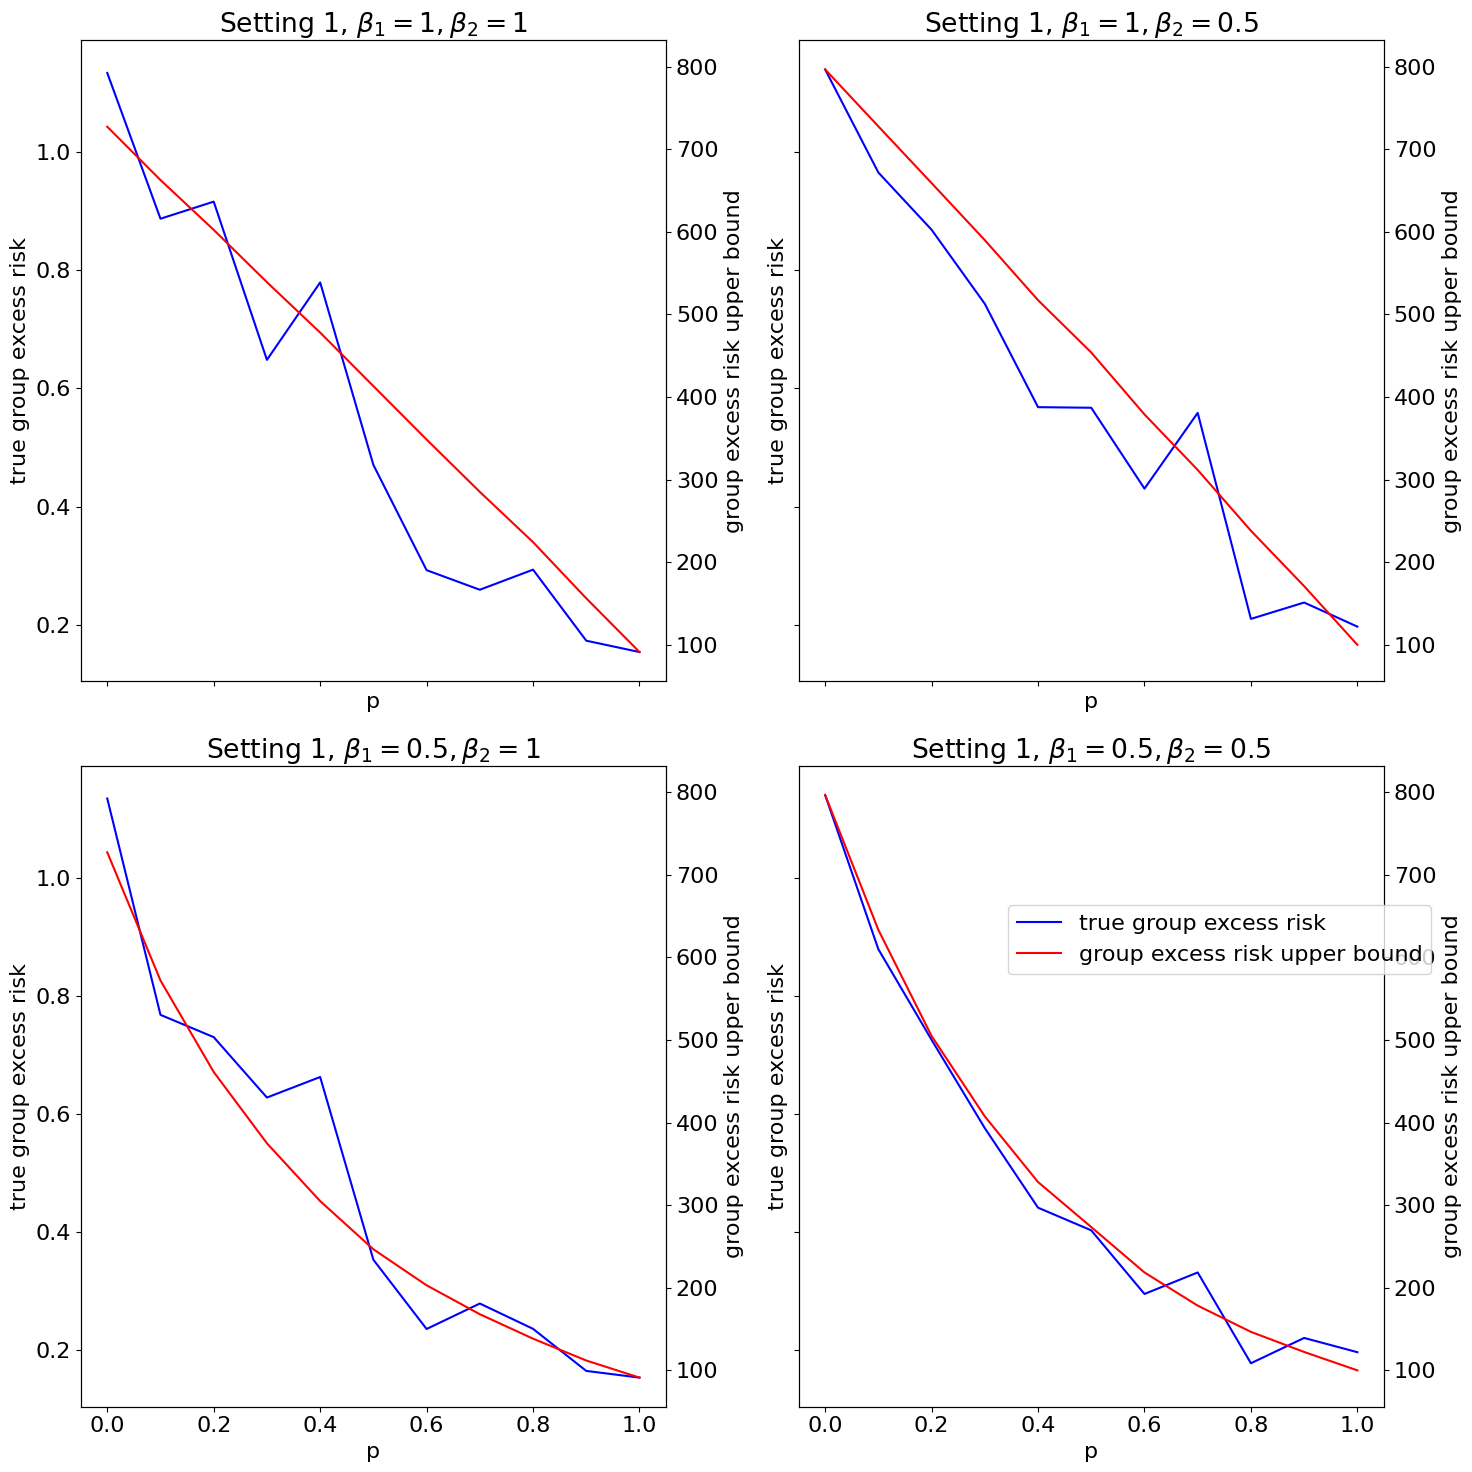

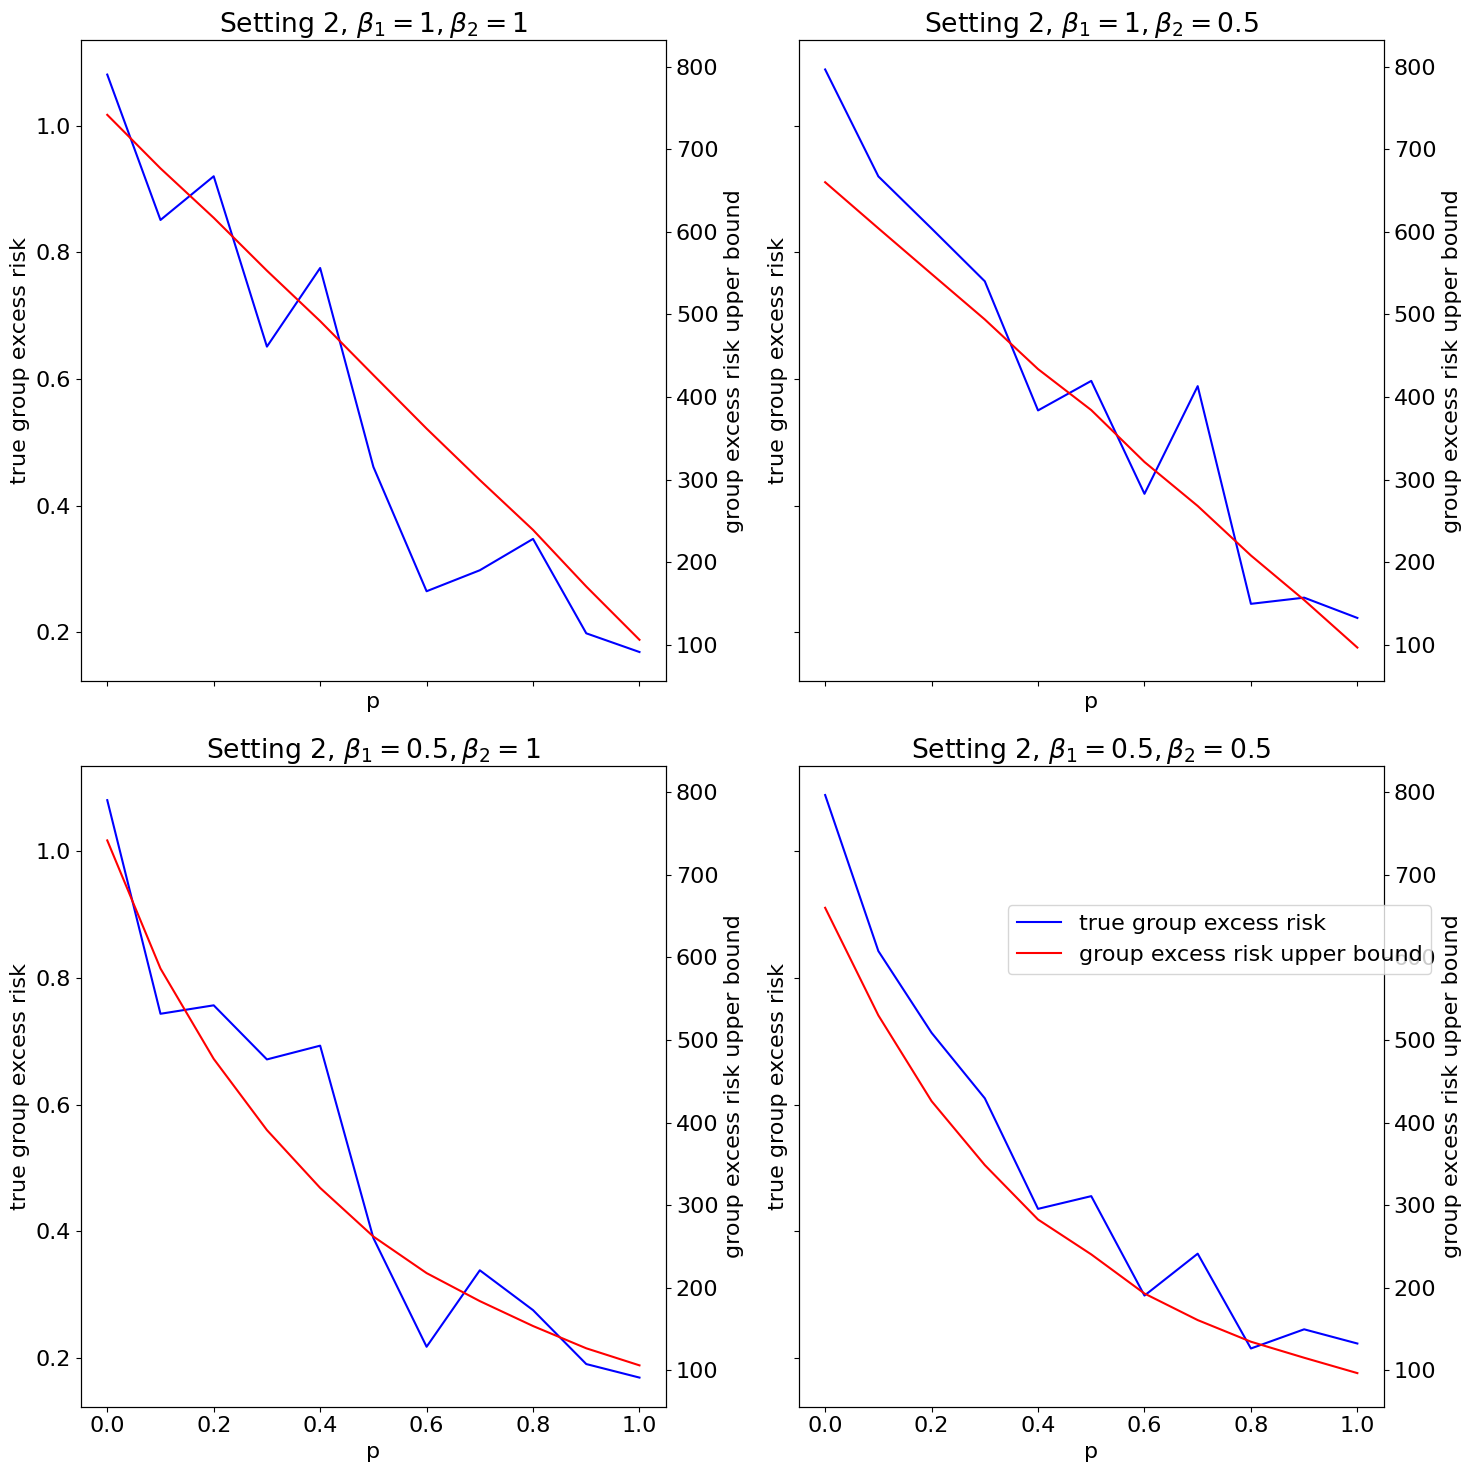

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

axs_list = []
for covars_0_idx in [0, 1]:
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 15))
    for beta_1_idx, beta_1 in enumerate([1, 0.5]):
        for beta_2_idx, beta_2 in enumerate([1, 0.5]):
            excess_risk_list, bound_list = results_dict[covars_0_idx][beta_1][beta_2]
            
            ax1 = axs[beta_1_idx, beta_2_idx]
            lns1 = ax1.plot(p_list, excess_risk_list.mean(dim=1), label='true group excess risk', c='b')
            ax2 = ax1.twinx()
            axs_list.append(ax2)
            lns2 = ax2.plot(p_list, bound_list.mean(dim=1), label='group excess risk upper bound', c='r')
            lns = lns1+lns2
            labs = [l.get_label() for l in lns]
            ax1.set_xlabel('p')
            ax1.set_ylabel('true group excess risk')
            ax2.set_ylabel('group excess risk upper bound')
            plt.title(r"Setting {}, $\beta_1 = {}, \beta_2 = {}$".format(covars_0_idx + 1, beta_1, beta_2))
    
    axs_list[0].get_shared_y_axes().join(axs_list[0], *axs_list[1:])
    plt.legend(lns, labs, bbox_to_anchor=(1.1, 0.8))
    plt.tight_layout()
    plt.show()